In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#2.1 Get the file
downloaded = drive.CreateFile({'id':'1Bsree3EgNi3su_vHzcnbijoYXrL51F-O'}) # replace the id with id of file you want to access
downloaded.GetContentFile('stock_data.csv')

In [4]:
import pandas as pd

In [5]:
df=pd.read_csv('stock_data.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [6]:
df.iloc[1000,0]

'INVN reports next week & is 3rd with a 13.5% gain this year #13for2013 (watch cup w/ handle - wkly)  '

In [7]:
df.iloc[1001,1]

1

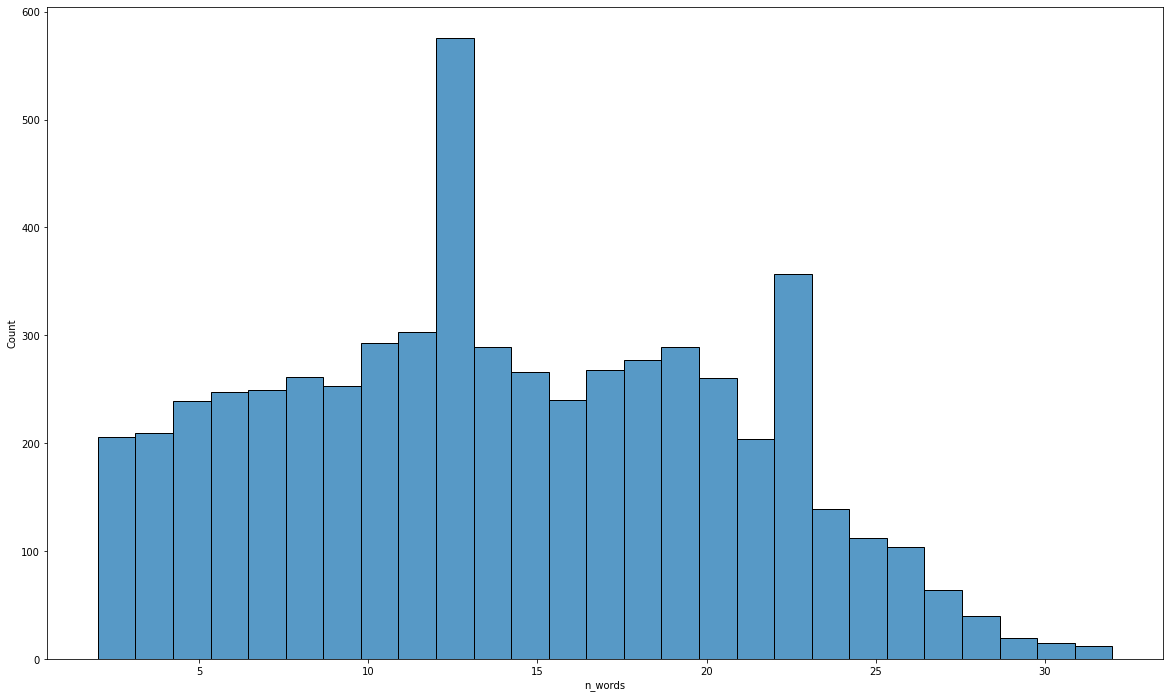

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 12))
# finding ideal length to use for further process
df['n_words'] = df['Text'].apply(lambda x:len(x.split()))
sns.histplot(data = df, x='n_words')
plt.show()

In [10]:
df.head()

,Text,Sentiment,n_words
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,20
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,16
2,user I'd be afraid to short AMZN - they are lo...,1,18
3,MNTA Over 12.00,1,3
4,OI Over 21.37,1,3


In [11]:
# now we need to one_hot encode the reviews
sentiment = pd.get_dummies(df.Sentiment)
data_3 = pd.concat([df,sentiment],axis=1)
data_3.head()

,Text,Sentiment,n_words,-1,1
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,20,0,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,16,0,1
2,user I'd be afraid to short AMZN - they are lo...,1,18,0,1
3,MNTA Over 12.00,1,3,0,1
4,OI Over 21.37,1,3,0,1


In [12]:
data_3.drop(columns=['n_words','Sentiment'],inplace=True)

In [14]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# now we will tokenize the words to sequence so that our model can understand
# we will also pad the sentences with less than 40 words to make size of each sentence equal
tokenizer = Tokenizer()
max_len = 590
tokenizer.fit_on_texts(data_3['Text'].values)
sequences = tokenizer.texts_to_sequences(data_3['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(sequences, maxlen=max_len, padding='post')

Found 10187 unique tokens.


In [16]:
y=data_3[[-1,1]]
y.shape

(5791, 2)

In [17]:
from sklearn.model_selection import train_test_split

# splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train.shape,X_test.shape

((5733, 590), (58, 590))

In [18]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, SpatialDropout1D, Embedding, LSTM
model = Sequential()

In [21]:
n_most_words = 23092
n_dim = 50
model.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50,dropout=0.25,recurrent_dropout=0.25))
model.add(Dense(25,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 590, 50)           1154600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 590, 50)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
 embedding_1 (Embedding)     (None, 3, 50)             1154600   
                                                        

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(patience=5)
model_history = model.fit(X_train,y_train,epochs=30,validation_split = 0.1, batch_size = 128 ,callbacks=[checkpoint,early_stop])

Epoch 1/30


41/41 [==============================] - 20s 334ms/step - loss: 0.6662 - acc: 0.6377 - val_loss: 0.6623 - val_acc: 0.6237
Epoch 2/30
41/41 [==============================] - 13s 319ms/step - loss: 0.6550 - acc: 0.6389 - val_loss: 0.6633 - val_acc: 0.6237
Epoch 3/30
41/41 [==============================] - 13s 320ms/step - loss: 0.6552 - acc: 0.6389 - val_loss: 0.6622 - val_acc: 0.6237
Epoch 4/30
41/41 [==============================] - 14s 336ms/step - loss: 0.6549 - acc: 0.6389 - val_loss: 0.6632 - val_acc: 0.6237
Epoch 5/30
41/41 [==============================] - 13s 323ms/step - loss: 0.6545 - acc: 0.6389 - val_loss: 0.6626 - val_acc: 0.6237
Epoch 6/30
41/41 [==============================] - 13s 324ms/step - loss: 0.6547 - acc: 0.6389 - val_loss: 0.6625 - val_acc: 0.6237
Epoch 7/30
41/41 [==============================] - 14s 351ms/step - loss: 0.6547 - acc: 0.6389 - val_loss: 0.6623 - val_acc: 0.6237
Epoch 8/30
41/41 [==============================] - 13s 328ms/step - loss: 0.654

In [23]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

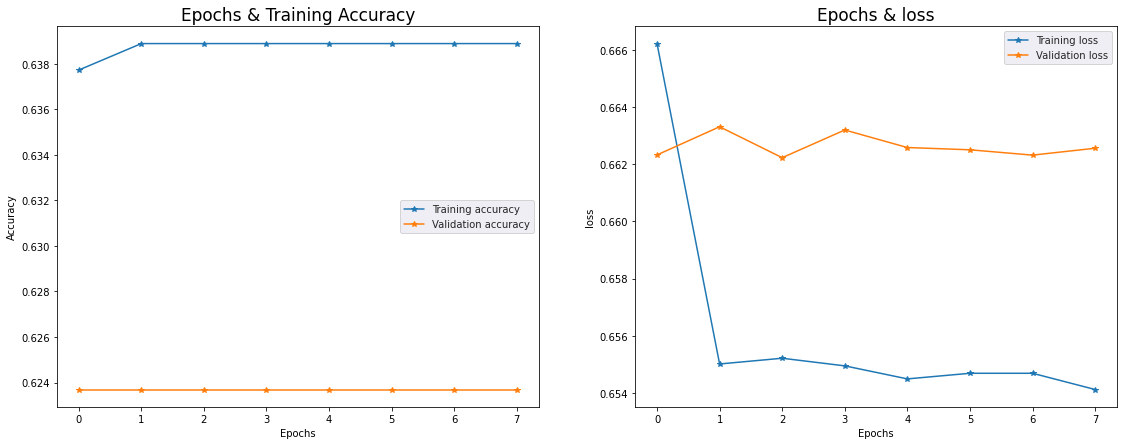

In [24]:
ig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")